In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportion_confint
from scipy import stats as stats
import pingouin as pg
from matplotlib import pyplot

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_ind, sem, beta, laplace, mannwhitneyu
)

%matplotlib inline

---


## Подготовка


In [2]:
# Импорт данных
dating_data = pd.read_csv(r'data\dating_data.csv')
dating_data

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [3]:
# проверка типов колонок
dating_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [4]:
# проверка на NULL значения
dating_data.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [5]:
# Общее число кликов для каждого пользователя
clicks = dating_data.groupby(['group', 'user_id_1'], as_index=0).agg({'is_match': 'count'})\
    .rename(columns={'is_match': 'clicks', 'user_id_1': 'user'})

# Среднее число мэтчей у пользователя, то есть отношение мэтчей ко всем кликам (конверсия в мэтч)
dating_avg_match_user = dating_data.groupby('user_id_1', as_index=0).agg({'group': 'mean', 'is_match': 'mean'})\
                                   .rename(columns={'is_match': 'avg_match'})

# мэтчей у каждого пользователя
match_per_user = dating_data.groupby('user_id_1', as_index=0).agg(
    {'group': 'mean', 'is_match': 'sum'})

---


## Сравнение мэтчей тестом Хи^2


Тест проверяет H0 о том, разницы между группами нет, альтернативная гипотеза разница есть


In [6]:
print(
    f"MDE - {round(pg.power_chi2(dof=1, n=dating_data.count()[0], power=0.8, alpha=0.05), 3)}")

MDE - 0.023


MDE нашего теста 2% то есть мы сможем зафиксировать еффект размером 2% при условии, что он есть


In [7]:
expected, observed, stats = pg.chi2_independence(
    dating_data, x='group', y='is_match')

In [8]:
print('Ожидаемая таблица частот\n')
print(expected)

print('\n--------------------------------------------\n')

print('Существующая таблица частот\n')
print(observed)

Ожидаемая таблица частот

is_match            0            1
group                             
0         3193.015847  1598.984153
1         6477.984153  3244.015847

--------------------------------------------

Существующая таблица частот

is_match       0       1
group                   
0         3857.5   934.5
1         5813.5  3908.5


Тест Хи^2 показывает значимое отличие тестовой группы от контрольной


In [9]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,618.688914,1.0,1.441830e-136,0.206463,1.0
1,cressie-read,0.666667,628.560791,1.0,1.027630e-138,0.208104,1.0
2,log-likelihood,0.000000,652.966812,1.0,5.056969e-144,0.212106,1.0
3,freeman-tukey,-0.500000,675.931262,1.0,5.125545e-149,0.215803,1.0
4,mod-log-likelihood,-1.000000,703.556093,1.0,5.039774e-155,0.220169,1.0
5,neyman,-2.000000,775.869247,1.0,9.519662e-171,0.231207,1.0


#### t-test проверяет нулевую гипотезу о том что среднее выборок равно. Так как наблюдений достаточно много мы можем использовать t-test.


## Клики у каждого из пользователей


In [10]:
clicks.head()

,group,user,clicks
0,0,4,9
1,0,10,6
2,0,12,12
3,0,14,8
4,0,15,20


<Axes: xlabel='clicks', ylabel='Count'>

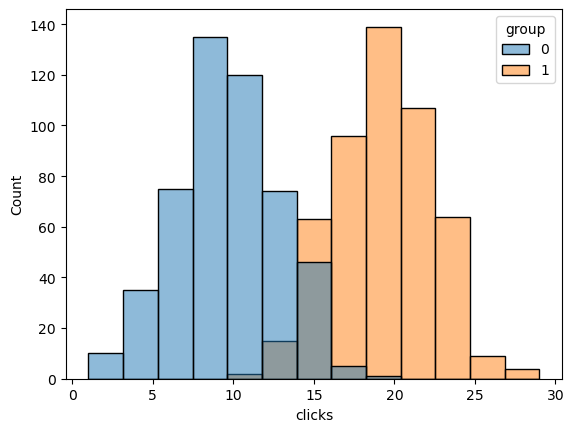

In [11]:
sns.histplot(x=clicks.clicks, hue=clicks.group)

Text(0.5, 1.0, 'Количество кликов у пользователя')

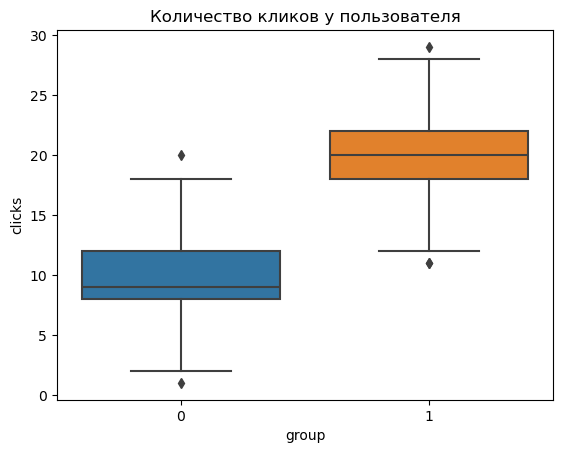

In [12]:
plt = sns.boxplot(data=clicks, x='group', y='clicks')
plt.set_title('Количество кликов у пользователя')

In [13]:
pg.homoscedasticity(clicks, dv='clicks', group='group')

,W,pval,equal_var
levene,0.480454,0.488378,True


In [14]:
pg.ttest(x=clicks.query("group == 1").clicks,
         y=clicks.query("group == 0").clicks, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,51.85607,997.694538,two-sided,2.005369e-285,"[9.54, 10.29]",3.279531,9.827e+280,1.0


т тест показывает значимое отличие групп между собой


## Конверсия в мэтч


In [15]:
dating_avg_match_user.head()

,user_id_1,group,avg_match
0,1,1.0,0.458333
1,2,1.0,0.437500
2,3,1.0,0.312500
3,4,0.0,0.222222
4,5,1.0,0.590909


<Axes: xlabel='avg_match', ylabel='Count'>

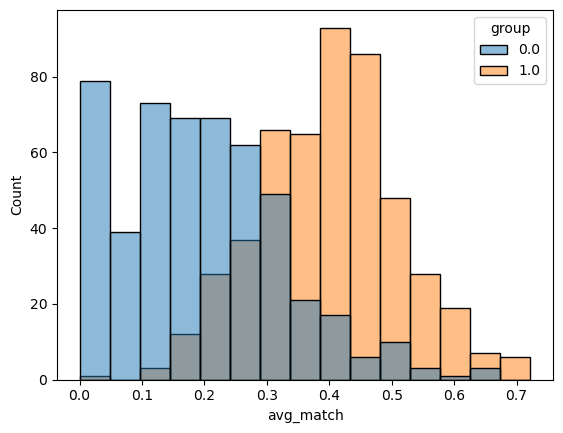

In [16]:
sns.histplot(x=dating_avg_match_user.avg_match,
             hue=dating_avg_match_user.group)

Text(0.5, 1.0, 'Конверсия в мэтч')

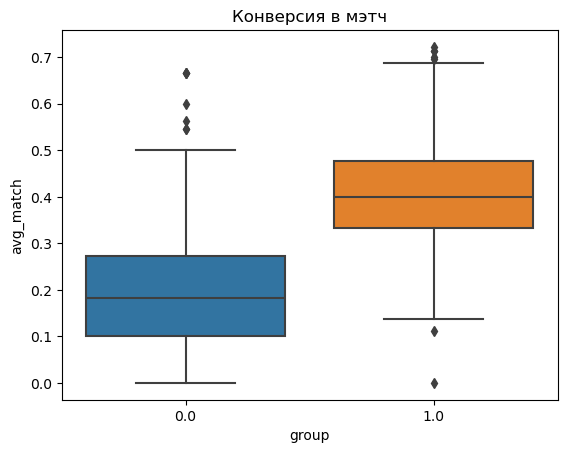

In [17]:
plt = sns.boxplot(data=dating_avg_match_user, x='group', y='avg_match')
plt.set_title('Конверсия в мэтч')

In [18]:
pg.homoscedasticity(dating_avg_match_user, dv='avg_match', group='group')

,W,pval,equal_var
levene,10.367478,0.001324,False


In [19]:
pg.ttest(x=dating_avg_match_user.query("group == 1").avg_match,
         y=dating_avg_match_user.query("group == 0").avg_match, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,26.427049,973.81603,two-sided,1.838391e-116,"[0.19, 0.22]",1.670856,1.314e+113,1.0


т тест показывает значимое отличие групп между собой


## Количество мэтчей


In [20]:
match_per_user.head()

,user_id_1,group,is_match
0,1,1.0,11
1,2,1.0,7
2,3,1.0,5
3,4,0.0,2
4,5,1.0,13


In [21]:
match_per_user.groupby('group').is_match.count()

group
0.0    501
1.0    499
Name: is_match, dtype: int64

<Axes: xlabel='is_match', ylabel='Count'>

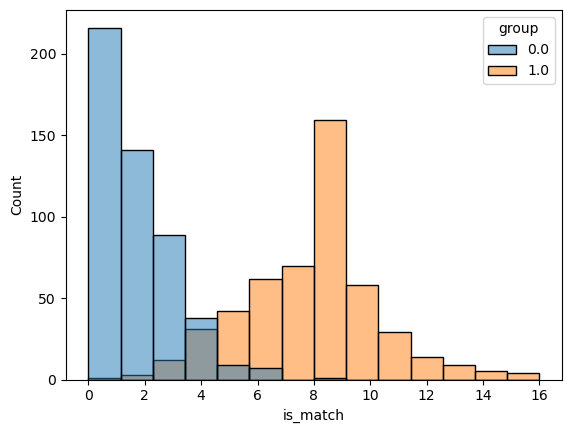

In [22]:
sns.histplot(x=match_per_user.is_match, hue=match_per_user.group)

Text(0.5, 1.0, 'Количество мэтчей у пользователя')

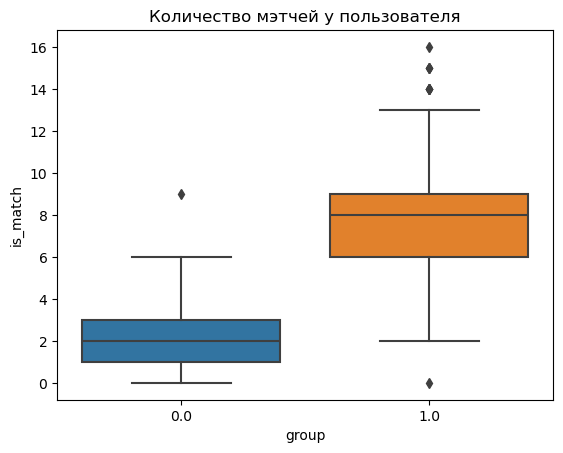

In [23]:
plt = sns.boxplot(data=match_per_user, x='group', y='is_match')
plt.set_title('Количество мэтчей у пользователя')

In [24]:
pg.homoscedasticity(match_per_user, dv='is_match', group='group')

,W,pval,equal_var
levene,134.174242,3.354548e-29,False


In [25]:
pg.ttest(x=match_per_user.query("group == 1").is_match,
         y=match_per_user.query("group == 0").is_match, paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,47.129786,772.18908,two-sided,2.129646e-229,"[5.72, 6.22]",2.983964,4.329e+251,1.0


т тест показывает значимое отличие групп между собой


## Проверка методом Монте-Карло


In [26]:
def check_criterion(test_dist, control_dist, sample_size, N_exps, to_print=True):
    """
        Функция для проверки t-test критерия для AB-теста
        Возвращает доверительный интервал для FPR, если флаг to_print = False. Иначе печатает результат.

        Параметры:
            - test_dist: Распределение тестовой выборки в эксперименте
            - control_dist: Распределение контрольной выборки в эксперименте
            - sample_size: размер выборки теста и контроля
            - N_exps: число экспериментов, по которым потом считается FPR
            - to_print: печатать результат или нет. Если нет, то функция возвращает дов. интервал для FPR.
    """
    bad_cnt = 0
    alpha = 0.05
    dist_mean_control = []
    dist_mean_test = []

    for i in range(N_exps):
        # Генерирую выборку
        test = np.random.choice(test_dist, size=sample_size, replace=True)
        control = np.random.choice(
            control_dist, size=sample_size, replace=True)

        # Запускаю критерий и считаю p-value
        pvalue = ttest_ind(test, control, equal_var=False).pvalue
        # pvalue = mannwhitneyu(test, control).pvalue

        # расчет бутстрап средних для теста и контроля
        dist_mean_control.append(np.mean(control))
        dist_mean_test.append(np.mean(test))

        # Проверяю, что pvalue > alpha => тест ошибся
        if pvalue > alpha:
            bad_cnt += 1

    diff_test_control = np.array(dist_mean_test) - np.array(dist_mean_control)
    ci_low = np.percentile(diff_test_control, 2.5)
    ci_upp = np.percentile(diff_test_control, 97.5)

    if to_print:
        print(f"error_rate: {(bad_cnt / N_exps)}")  # round
        print(
            f"CI={proportion_confint(count = bad_cnt, nobs = N_exps, alpha=alpha, method='wilson')}")
        print(
            f"95% доверительный интервал разницы тестовой и контрольной группы: {ci_low, ci_upp}")
        print(f"bad_cnt: {bad_cnt}")
        sns.histplot(dist_mean_control)
        sns.histplot(dist_mean_test)
    else:
        return proportion_confint(count=bad_cnt, nobs=N_exps, alpha=alpha, method='wilson')

error_rate: 0.0
CI=(2.168404344971009e-19, 0.003826758485555125)
95% доверительный интервал разницы тестовой и контрольной группы: (0.152, 0.264)
bad_cnt: 0


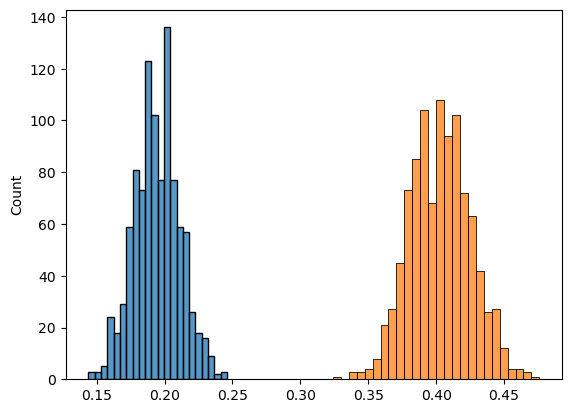

In [27]:
check_criterion(test_dist=dating_data.query("group == 1").is_match,
                control_dist=dating_data.query("group == 0").is_match, sample_size=500, N_exps=1000)

error_rate: 0.0
CI=(2.168404344971009e-19, 0.003826758485555125)
95% доверительный интервал разницы тестовой и контрольной группы: (5.6979, 6.207999999999999)
bad_cnt: 0


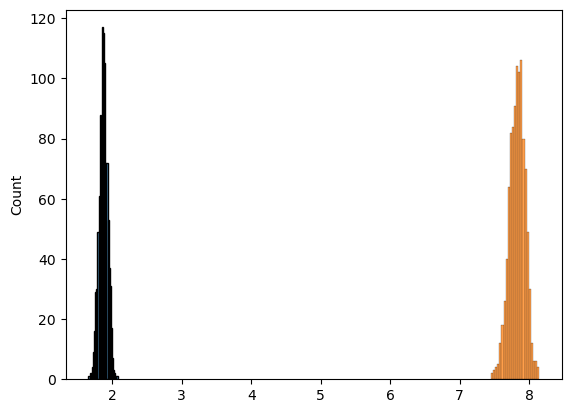

In [28]:
check_criterion(test_dist=match_per_user.query("group == 1").is_match,
                control_dist=match_per_user.query("group == 0").is_match, sample_size=500, N_exps=1000)

error_rate: 0.0
CI=(2.168404344971009e-19, 0.003826758485555125)
95% доверительный интервал разницы тестовой и контрольной группы: (9.5459, 10.26005)
bad_cnt: 0


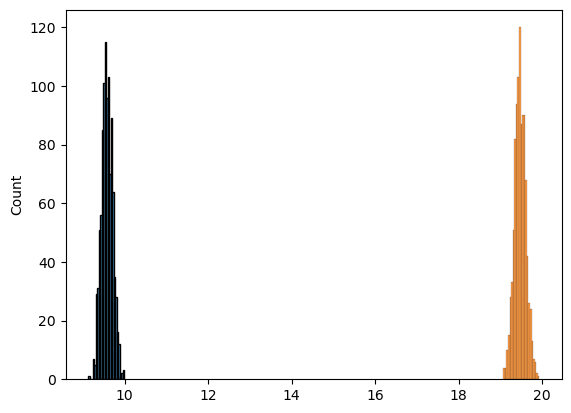

In [29]:
check_criterion(test_dist=clicks.query("group == 1").clicks, control_dist=clicks.query(
    "group == 0").clicks, sample_size=500, N_exps=1000)

error_rate: 0.0
CI=(2.168404344971009e-19, 0.003826758485555125)
95% доверительный интервал разницы тестовой и контрольной группы: (0.19109950522959587, 0.22368934286228942)
bad_cnt: 0


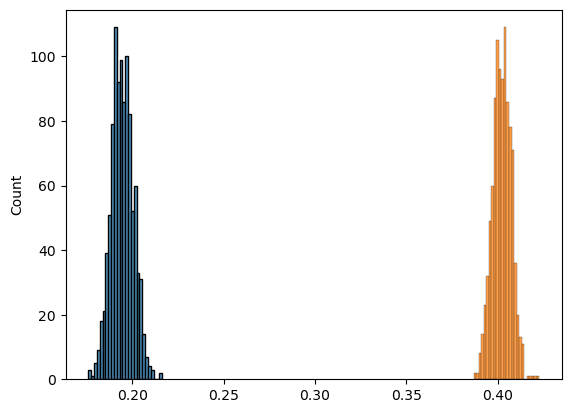

In [30]:
check_criterion(test_dist=dating_avg_match_user.query("group == 1").avg_match,
                control_dist=dating_avg_match_user.query("group == 0").avg_match, sample_size=500, N_exps=1000)

## Было проведено четыре A/B-теста для различных метрик, все тесты показали значимое отличие между группами.

Тесты:

1. Тест Хи-квадрат для бинарной переменной "мэтч" по группам.
2. Общее число кликов для каждого пользователя.
3. Среднее число "мэтчей" у пользователя, то есть отношение "мэтчей" ко всем кликам (конверсия в "мэтч").
4. Количество "мэтчей" у каждого пользователя.


### **Вывод:** Количество кликов у пользователя, количество "мэтчей", а также конверсия в "мэтч" (CR) в тестовой группе значимо больше, чем в контрольной группе. Следовательно, новый алгоритм улучшает качество сервиса и данный алгоритм можно включать для всех пользователей.


### В среднем наши изменения увеличивают количество кликов на 9.57 - 10.29,

### число мэтчей у пользователя на 5.73 - 6.21

### конверсию в мэтч на 0.19 - 0.22 %
